In [ ]:
pip install mindquantum

In [ ]:
pip install cvxpy

In [4]:
import numpy as np
import pandas as pd
import mindspore as ms
import math
import random
from pandas import DataFrame as DF
# from scipy.sparse import scr_matrix
import scipy.sparse as sp
from mindquantum.simulator import Simulator
from mindquantum.core.gates import I, X, Y, H, RY, RX, RZ, CNOT, Measure
from mindquantum.core.circuit import Circuit
from mindquantum.core.parameterresolver import PRGenerator
from mindquantum.core.operators import QubitOperator # QubitOperator模块用于Pauli
from mindquantum.core.operators import Hamiltonian # Hamiltonian模块用于H
from mindquantum.framework import MQLayer
from mindspore.nn import Adam, TrainOneStepCell
import matplotlib.pyplot as plt
import cvxpy as cp

In [5]:
def get_stock_returns(tickers, start, end, output):
    returns = pd.DataFrame()
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start, end=end)
        returns[ticker] = data['Close'].pct_change().dropna()
    returns.to_csv(output, index=False)  # 保存收益率数据到文件
    return returns, None

In [6]:
tickers = ['AKR','AMD','AMKR','AMZN','ANET','AROC','BAC','BAM','BK','BKKT','BKNG','BKR','BLK','CBOE','CHKP']
# returns, error = get_stock_returns(tickers, "2023-06-01", "2024-06-30", 'D:\\data.csv')
data = pd.read_csv('data.csv')
data

,AKR,AMD,AMKR,AMZN,ANET,AROC,BAC,BAM,BK,BKKT,BKNG,BKR,BLK,CBOE,CHKP
0,0.045879,-0.013476,0.035842,0.012055,-0.025078,0.034261,0.033477,0.028571,0.036121,0.006897,0.029667,0.033904,0.019467,0.011826,-0.001208
1,-0.018587,0.000594,-0.031425,0.008451,0.000800,0.002070,-0.005921,0.022177,-0.005148,-0.041096,0.017181,0.003043,-0.007876,-0.000888,-0.000323
2,0.038636,0.053422,0.026274,0.010455,-0.018139,0.023760,0.024176,0.015783,0.020931,-0.024119,0.013981,0.031008,0.012461,-0.024730,0.003145
3,0.046681,-0.051517,0.030644,-0.042493,-0.025614,0.024218,0.008553,-0.012741,0.006911,-0.007143,-0.023603,0.001634,-0.002485,0.009945,-0.003457
4,0.002787,0.027328,-0.002258,0.024911,0.043255,0.009852,-0.008480,-0.006925,0.003203,0.028777,0.001240,-0.011423,0.003465,0.019620,-0.000565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.015562,-0.006078,-0.029458,-0.018564,-0.024158,0.031646,0.013421,0.008430,0.011221,0.106667,-0.001980,0.044944,0.014411,-0.026036,-0.018067
266,-0.020431,-0.011495,0.052108,0.004149,0.016160,0.003068,-0.015992,0.001829,-0.011601,0.046386,0.008334,0.012787,-0.005707,-0.013950,-0.003077
267,0.011008,-0.016911,-0.002042,0.039015,0.000508,0.010194,-0.009650,-0.009648,-0.002041,0.077144,-0.007971,-0.010904,-0.008736,0.006274,0.006817
268,0.014327,0.012251,-0.005884,0.021900,0.039528,0.010091,0.006410,0.005529,0.014829,0.106895,0.006785,-0.001451,-0.008026,0.001588,0.039218


In [7]:
r = DF(data.iloc[-1,:]).reset_index(drop=True)
data = data.iloc[:-1, :]
r

,269
0,0.022831
1,0.017182
2,0.029851
3,-0.023250
4,0.007329
5,0.009990
6,0.013248
7,-0.003666
8,0.005878
9,-0.086432


In [8]:
n = 15
t = 252
h = 252
tao = 504
h_diag = 252
tao_diag = 84

def get_fn(data, n, t, h, tao):
    fn = []
    for i in range(n):
        summ = 0  # 分子molecule
        sumw = 0  # 分母权重weight
        for s in range(h):
            summ += pow(0.5, s / tao) * data.iloc[t - s - 1, i]
            sumw += pow(0.5, s / tao)
        fn.append(summ / sumw)
    return fn


# 求协方差
def get_V(data, n, t, h, tao, h_diag, tao_diag):
    V = pd.DataFrame(np.zeros(n * n).reshape(n, n))
    f_diag = get_fn(data, n, t, h_diag, tao_diag)  # 先解决对角线上要用到的因子收益加权均值
    f_ = get_fn(data, n, t, h, tao)
    for a in range(n):
        for b in range(n):
            summ = 0
            sumw = 0
            if (a == b):
                # 对角线上单独计算
                for s in range(h_diag):
                    summ += pow(0.5, s / tao_diag) * pow((data.iloc[t - s - 1, a] - f_diag[a]), 2)
                    sumw += pow(0.5, s / tao_diag)
                V.iloc[a, b] = summ / sumw
            elif a < b:
                for s in range(h):
                    summ += pow(0.5, s / tao) * (data.iloc[t - s - 1, a] - f_[a]) * (
                                data.iloc[t - s - 1, b] - f_[b])
                    sumw += pow(0.5, s / tao)
                V.iloc[a,b] = summ / sumw
            else:
                V.iloc[a,b] = V.loc[b,a]
    return V

# V = get_V(data, n, t, h, tao, h_diag, tao_diag)
# V.to_csv('D:\\V.csv', index=False)
V = pd.read_csv('V.csv')
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000257,5.190000e-05,0.000141,0.000032,0.000023,0.000075,0.000156,0.000122,0.000102,0.000261,0.000056,7.400000e-05,0.000114,-0.000008,0.000013
1,0.000052,8.755720e-04,0.000396,0.000239,0.000368,0.000073,0.000045,0.000192,0.000071,0.000163,0.000171,-7.210000e-07,0.000117,0.000003,0.000031
2,0.000141,3.960260e-04,0.000632,0.000112,0.000244,0.000117,0.000119,0.000190,0.000085,0.000371,0.000129,6.890000e-05,0.000137,-0.000050,0.000003
3,0.000032,2.390090e-04,0.000112,0.000270,0.000172,0.000024,0.000015,0.000106,0.000030,0.000193,0.000123,9.580000e-06,0.000069,-0.000003,0.000023
4,0.000023,3.675220e-04,0.000244,0.000172,0.000699,0.000120,0.000028,0.000098,0.000035,0.000252,0.000118,1.480000e-05,0.000080,-0.000003,0.000057
5,0.000075,7.320000e-05,0.000117,0.000024,0.000120,0.000369,0.000095,0.000103,0.000079,0.000318,0.000069,1.278190e-04,0.000057,0.000006,0.000003
6,0.000156,4.470000e-05,0.000119,0.000015,0.000028,0.000095,0.000207,0.000137,0.000123,0.000253,0.000049,7.830000e-05,0.000120,-0.000006,0.000019
7,0.000122,1.921690e-04,0.000190,0.000106,0.000098,0.000103,0.000137,0.000266,0.000098,0.000450,0.000112,7.190000e-05,0.000134,-0.000004,0.000022
8,0.000102,7.090000e-05,0.000085,0.000030,0.000035,0.000079,0.000123,0.000098,0.000122,0.000178,0.000050,6.130000e-05,0.000090,0.000014,0.000028
9,0.000261,1.634310e-04,0.000371,0.000193,0.000252,0.000318,0.000253,0.000450,0.000178,0.010651,0.000166,1.803200e-04,0.000332,0.000048,0.000163


# 计算合适的gamma的取值

In [9]:
w0 = np.ones(15)/15
np.dot(w0,r) / np.dot(np.dot(w0,V),w0)

array([9.94437881])

In [10]:
np.dot(w0,r)

array([0.0015755])

In [11]:
np.dot(np.dot(w0,V),w0)

0.00015843081777777775

In [12]:
gamma = 15
Vtemp = pd.read_csv('V.csv')
Vtemp *= 2*gamma
for i in range(n):
    Vtemp.iloc[i, i] += 1

e = DF(np.ones(n))
eT = DF(np.ones(n+1)).T
M = DF(np.vstack((np.hstack((Vtemp, e)), eT)))
M.iloc[-1,-1]=0
M

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.007708,0.001557,0.004232,0.000975,0.000702,0.002262,0.004670,0.003668,0.003074,0.007830,0.001692,0.002220,0.003424,-0.000229,0.000384,1.0
1,0.001557,1.026267,0.011881,0.007170,0.011026,0.002196,0.001341,0.005765,0.002127,0.004903,0.005130,-0.000022,0.003517,0.000089,0.000936,1.0
2,0.004232,0.011881,1.018955,0.003368,0.007318,0.003516,0.003576,0.005712,0.002559,0.011136,0.003874,0.002067,0.004105,-0.001506,0.000087,1.0
3,0.000975,0.007170,0.003368,1.008089,0.005149,0.000708,0.000447,0.003171,0.000906,0.005802,0.003703,0.000287,0.002070,-0.000094,0.000678,1.0
4,0.000702,0.011026,0.007318,0.005149,1.020958,0.003597,0.000831,0.002937,0.001056,0.007559,0.003542,0.000444,0.002388,-0.000100,0.001704,1.0
5,0.002262,0.002196,0.003516,0.000708,0.003597,1.011072,0.002862,0.003101,0.002358,0.009539,0.002073,0.003835,0.001719,0.000188,0.000103,1.0
6,0.004670,0.001341,0.003576,0.000447,0.000831,0.002862,1.006221,0.004108,0.003686,0.007576,0.001485,0.002349,0.003591,-0.000182,0.000573,1.0
7,0.003668,0.005765,0.005712,0.003171,0.002937,0.003101,0.004108,1.007965,0.002943,0.013514,0.003366,0.002157,0.004013,-0.000135,0.000651,1.0
8,0.003074,0.002127,0.002559,0.000906,0.001056,0.002358,0.003686,0.002943,1.003667,0.005327,0.001488,0.001839,0.002712,0.000414,0.000849,1.0
9,0.007830,0.004903,0.011136,0.005802,0.007559,0.009539,0.007576,0.013514,0.005327,1.319522,0.004974,0.005410,0.009952,0.001434,0.004894,1.0


# 进入循环

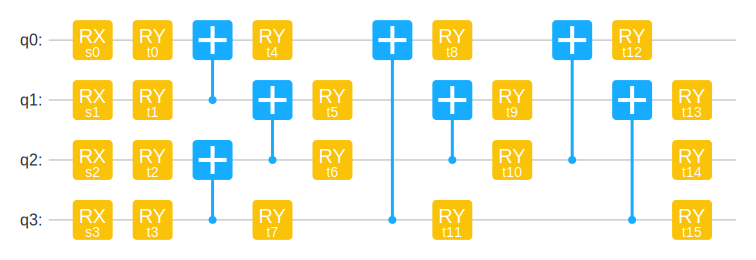

In [13]:
s = PRGenerator('s')
e = Circuit()
for i in range(4):
    e += RX(s.new()).on(i)
e = e.no_grad()
e.as_encoder()

t = PRGenerator('t')
a = Circuit()
for i in range(4):
    a += RY(t.new()).on(i)
a += CNOT.on(2,3)
a += CNOT.on(0,1)
a += CNOT.on(1,2)

for i in range(4):
    a += RY(t.new()).on(i)

a += CNOT.on(0,3)
a += CNOT.on(1,2)

for i in range(4):
    a += RY(t.new()).on(i)

a += CNOT.on(0,2)
a += CNOT.on(1,3)
for i in range(4):
    a += RY(t.new()).on(i)
    # a += RY(t.new()).on(i)
a.as_ansatz()

c = e.as_encoder() + a.as_ansatz()

c.svg()

In [17]:
c.svg().to_file(filename='c.jpg')

In [14]:
j = 1
rou = 1
x,z,miu = DF(np.zeros(15)),DF(np.zeros(15)),DF(np.zeros(15))
Res = []

In [15]:
while(1):
    b = r.iloc[:,0] + rou*(z.iloc[:,j-1]-miu.iloc[:,j-1])
    b[15] = 1
    b = DF(b/np.linalg.norm(b))
    ham = DF(np.dot(np.dot(M,(np.eye(16)-np.dot(b,b.T))),M))
    Ham = Hamiltonian(sp.csr_matrix(ham.values))
    s0, s1, s2, s3 = 0, 0, 0, 0
    t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15 = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    e_data = np.array([[s0, s1, s2, s3]]).astype(np.float32)
    a_data = np.array([t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15]).astype(np.float32)
    
    sim = Simulator('mqvector', n_qubits=4)
    grad_ops = sim.get_expectation_with_grad(Ham, c)
    f, g_e, g_a = grad_ops(e_data,a_data)
    ms.set_seed(1)
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target='CPU')
    qnet = MQLayer(grad_ops)
    opt = Adam(qnet.trainable_params(), learning_rate = 0.5)
    net = TrainOneStepCell(qnet, opt)
    for i in range(150):
        res = net(ms.Tensor(e_data))
        # if i % 10 == 0:
        #     print(i, ': ', res)
    opt = Adam(qnet.trainable_params(), learning_rate = 0.2)
    net = TrainOneStepCell(qnet, opt)
    for i in range(200):
        res = net(ms.Tensor(e_data))
        # if i%10 == 0:
        #     print(i, ': ', res)
    print(j,res)
    Res.append(res.asnumpy()[0][0])
    
    t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15 = qnet.weight.asnumpy()
    xj = DF(c.get_qs(pr=dict(zip(c.params_name, [s0,s1,s2,s3,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15]))).real)
    # print(j,xj)
    xj = xj / xj.iloc[:15].sum()
    # print('经典：',gamma * np.dot(np.dot(np.linalg.solve(M,b).flatten()[:15],V), np.linalg.solve(M,b).flatten()[:15]) - np.dot(np.linalg.solve(M,b).flatten()[:15], r))
    # print('量子：',gamma * np.dot(np.dot(xj.iloc[:15,0],V), xj.iloc[:15,0]) - np.dot(xj.iloc[:15,0], r))
    # print(j,xj)
    print(j, (gamma * np.dot(np.dot(xj.iloc[:15,0].T,V), xj.iloc[:15,0]) - np.dot(xj.iloc[:15,0].T, r))[0],'\n')
    
    x = pd.concat([x,xj.iloc[:15,0]],axis=1,ignore_index=True)
    zj = x.iloc[:,j] + miu.iloc[:,j-1]
    zj = zj.apply(lambda x: 0 if x < 0 else 1 if x > 1 else x)
    z = pd.concat([z,zj],axis=1,ignore_index=True)
    miuj = miu.iloc[:,j-1]+x.iloc[:,j]-z.iloc[:,j]
    miu = pd.concat([miu,miuj],axis=1,ignore_index=True)
    
    # if (np.mean(abs(x.iloc[:,j]) - abs(z.iloc[:,j]))<0.00001 and np.mean(abs(z.iloc[:,j]) - abs(z.iloc[:,j-1]))<0.00001 and j>100):
    if (np.mean(abs(x.iloc[:,j]) - abs(z.iloc[:,j]))<0.001 and np.mean(abs(z.iloc[:,j]) - abs(z.iloc[:,j-1]))<0.001 and j>=120):
    # if j>=30:
        print(np.mean(abs(x.iloc[:,j]) - abs(z.iloc[:,j])), np.mean(abs(z.iloc[:,j]) - abs(z.iloc[:,j-1])))
        break
    j += 1

1 [[9.77962e-06]]
1 -0.010845589572790536 

2 [[9.454084e-05]]
2 -0.01668440883249322 

3 [[1.0567565e-10]]
3 -0.015554971883981979 

4 [[8.424447e-06]]
4 -0.01555727016906601 

5 [[6.879402e-10]]
5 -0.01589519382964255 

6 [[2.0245402e-06]]
6 -0.01633557224527452 

7 [[0.00136353]]
7 -0.016968967885098094 

8 [[1.3616868e-07]]
8 -0.016925077839942772 

9 [[4.979932e-10]]
9 -0.017528420672039448 

10 [[5.8150995e-10]]
10 -0.018150048574477107 

11 [[2.81684e-10]]
11 -0.018499994102300715 

12 [[2.874965e-10]]
12 -0.01882867311867025 

13 [[3.3201253e-10]]
13 -0.019228529039711343 

14 [[3.3996186e-09]]
14 -0.019769035782849505 

15 [[1.5848861e-10]]
15 -0.01990150574277454 

16 [[2.3686356e-10]]
16 -0.019957981175419442 

17 [[1.2351883e-10]]
17 -0.020144655350592316 

18 [[7.485328e-11]]
18 -0.020384098811035065 

19 [[1.5677795e-10]]
19 -0.020504110456347015 

20 [[2.2485729e-10]]
20 -0.02070051014231839 

21 [[9.6240155e-11]]
21 -0.02071612173468375 

22 [[1.3052984e-10]]
22 -0.0207

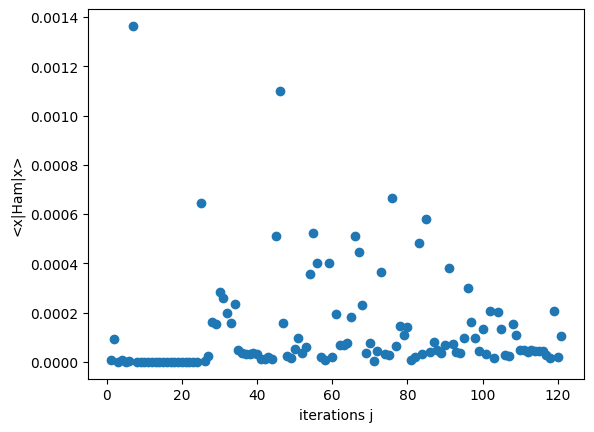

In [16]:
xvalue = [i for i in range(1, 122)]
plt.scatter(xvalue,Res)
plt.xlabel('iterations j')  
plt.ylabel('<x|Ham|x>')
plt.savefig('Ham.png')
plt.show()

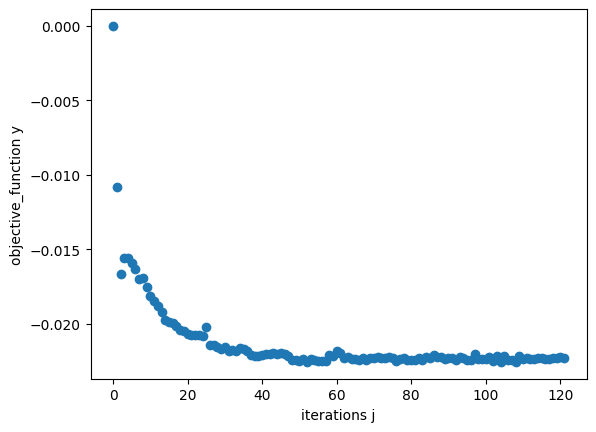

In [17]:
# 最终还是回归了0.001 and 0.001 and 120
xvalue = []
yvalue = []
for j in range(0,122):
    temp = gamma * np.dot(np.dot(x.iloc[:15,j],V),x.iloc[:15,j]) - np.dot(x.iloc[:15,j], r)
    # print(j, ':', temp)
    xvalue.append(j)
    yvalue.append(temp)
plt.scatter(xvalue,yvalue)
plt.xlabel('iterations j')  
plt.ylabel('objective_function y')
# plt.ylim(6,10)
plt.savefig('yj.png')
plt.show()

In [18]:
x.iloc[:,-1].values

array([ 2.43929843e-01, -1.48296628e-03,  4.80616983e-01, -6.96886244e-04,
        5.56502021e-05,  2.69331050e-03, -4.21995417e-04,  3.87218790e-03,
       -2.43143670e-04, -3.99785463e-04, -9.07155027e-04,  2.72523170e-01,
        6.20030959e-04, -1.51856999e-04, -7.38576272e-06])

# cvxpy经典对照

In [19]:
w = cp.Variable(n)
objective = cp.Minimize(gamma * cp.quad_form(w,V) - w.T @ r)
constraints = [cp.sum(w) == 1, w>=0]

problem = cp.Problem(objective, constraints)
problem.solve()

-0.022361270760996213

In [20]:
w.value

array([ 1.92118776e-01,  2.10135440e-22,  5.25081379e-01,  7.49192735e-23,
        9.69256530e-23,  1.48358147e-22,  9.86542067e-23,  6.50809847e-23,
        1.67722455e-22, -6.30689551e-23,  7.13622351e-23,  2.82799845e-01,
        1.64311697e-22,  6.53047173e-23,  6.70058343e-23])

# 错误合集

### 将向量b模拟为量子态

In [ ]:
s = PRGenerator('s')
e = Circuit()
for i in range(4):
    e += RX(s.new()).on(i)
e = e.no_grad()
e.as_encoder()

t = PRGenerator('t')
a = Circuit()
for i in range(4):
    a += RY(t.new()).on(i)
a += CNOT.on(2,3)
a += CNOT.on(0,1)
for i in range(4):
    a += RY(t.new()).on(i)
a += CNOT.on(0,2)
a += CNOT.on(1,3)
for i in range(4):
    a += RY(t.new()).on(i)
a.as_ansatz()

c = e.as_encoder() + a.as_ansatz()
c.svg()

x = b.values.flatten()
sim = Simulator(backend='mqvector', n_qubits=4)
sim.set_qs(x)
print(sim.get_qs(ket=True))
print(sim)

# 损失函数设定为对每个qubit应用Pauli-Z门
H = Hamiltonian((QubitOperator('Z0',1)+QubitOperator('Z1',1)+QubitOperator('Z2',1)+QubitOperator('Z3',1))/4)
grad_ops = sim.get_expectation_with_grad(H, c)
f, e_g, a_g = grad_ops(e_data, a_data)
ms.set_seed(1)
ms.set_context(mode=ms.PYNATIVE_MODE, device_target='CPU')
qnet = MQLayer(grad_ops)
opt = Adam(qnet.trainable_params(), learning_rate = 0.5)
net = TrainOneStepCell(qnet, opt)
for i in range(150):
    res = net(ms.Tensor(e_data))
    if i%10 == 0:
        print(i, ': ', res)
opt = Adam(qnet.trainable_params(), learning_rate = 0.1)
net = TrainOneStepCell(qnet, opt)
for i in range(200):
    res = net(ms.Tensor(e_data))
    if i%10 == 0:
        print(i, ': ', res)
        
t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11 = qnet.weight.asnumpy()
dict(zip(e.params_name+a.params_name, [s0, s1, s2, s3,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]))
print(c.get_qs(pr=dict(zip(e.params_name+a.params_name, [s0, s1, s2, s3,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11])),ket=True))

ti = PRGenerator('ti')
ci = Circuit()
for i in range(4):
    ci += X.on(i)
    ci += RY(ti.new()).on(i)
ci += CNOT(1,3)
ci += CNOT(0,2)
for i in range(4):
    ci += RY(ti.new()).on(i)
ci += CNOT(0,1)
ci += CNOT(2,3)
for i in range(4):
    ci += RY(ti.new()).on(i)
ci.svg()

dict(zip(ci.params_name, [-t8,-t9,-t10,-t11,-t4,-t5,-t6,-t7,-t0,-t1,-t2,-t3]))
# 实现共轭转置时，量子门的参数取相反数、顺序也需要调整
print(ci.get_qs(pr=dict(zip(ci.params_name, [-t8,-t9,-t10,-t11,-t4,-t5,-t6,-t7,-t0,-t1,-t2,-t3])),ket=True))

### 将系数矩阵M拆分成Pauli矩阵的线性组合

In [ ]:
# 定义Pauli矩阵
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
matrix_map = {'I': I, 'X': X, 'Y': Y, 'Z': Z} 

ls0 = ['IIII','IIIZ','IIZI','IIZZ','IZII','IZIZ','IZZI','IZZZ','ZIII','ZIIZ','ZIZI','ZIZZ','ZZII','ZZIZ','ZZZI','ZZZZ'] #0
ls1 = ['IIIX','IIZX','IZIX','IZZX','ZIIX','ZIZX','ZZIX','ZZZX'] #1
ls2 = ['IIXI','IIXZ','IZXI','IZXZ','ZIXI','ZIXZ','ZZXI','ZZXZ'] #2
ls3 = ['IIXX','IIYY','IZXX','IZYY','ZIXX','ZIYY','ZZXX','ZZYY'] #3
ls4 = ['IXII','IXIZ','IXZI','IXZZ','ZXII','ZXIZ','ZXZI','ZXZZ'] #4
ls5 = ['IXIX','IXZX','IYIY','IYZY','ZXIX','ZXZX','ZYIY','ZYZY'] #5
ls6 = ['IXXI','IXXZ','IYYI','IYYZ','ZXXI','ZXXZ','ZYYI','ZYYZ'] #6
ls7 = ['IXXX','IXYY','IYXY','IYYX','ZXXX','ZXYY','ZYXY','ZYYX'] #7
ls8 = ['XIII','XIIZ','XIZI','XIZZ','XZII','XZIZ','XZZI','XZZZ'] #8
ls9 = ['XIIX','XIZX','XZIX','XZZX','YIIY','YIZY','YZIY','YZZY'] #9
ls10 = ['XIXI','XIXZ','XZXI','XZXZ','YIYI','YIYZ','YZYI','YZYZ'] #10
ls11 = ['XIXX','XIYY','XZXX','XZYY','YIXY','YIYX','YZXY','YZYX'] #11
ls12 = ['XXII','XXIZ','XXZI','XXZZ','YYII','YYIZ','YYZI','YYZZ'] #12
ls13 = ['XXIX','XXZX','XYIY','XYZY','YXIY','YXZY','YYIX','YYZX'] #13
ls14 = ['XXXI','XXXZ','XYYI','XYYZ','YXYI','YXYZ','YYXI','YYXZ'] #14
ls15 = ['XXXX','XXYY','XYXY','XYYX','YXXY','YXYX','YYXX','YYYY'] #15
lists = [ls0, ls1, ls2, ls3, ls4, ls5, ls6, ls7, ls8, ls9, ls10, ls11, ls12, ls13, ls14, ls15]

answers = []

for i,ls in enumerate(lists):
    coefficient = DF(np.zeros(16)) # 放origin，非零元素的列坐标
    product = DF(np.zeros(16))
    for item in ls:
        pauli = DF(np.kron(matrix_map[item[0]], np.kron(matrix_map[item[1]], np.kron(matrix_map[item[2]], matrix_map[item[3]]))))
        # np.nonzero返回一个元组，包含了非零元素每个维度上的坐标。这句只要了列坐标，反正每列就一个非零
        non_zero_index = np.nonzero(pauli)[1] 
        origin = DF(np.zeros(16))
        for j in range(16):
            # 把每个直积矩阵中每行的非零值的数值压缩到16*1的dataframe里，而且只要实部——注意是数，±1，不是坐标
            origin.iloc[j,0] = pauli.iloc[j,non_zero_index[j]].real 
        coefficient = pd.concat([coefficient, origin], axis=1)
    coefficient = coefficient.iloc[:,1:] # 因为拼接时把初始值的全零列也算上了，最后要去掉
    for j in range(16):
        product.iloc[j,0] = M.iloc[j,non_zero_index[j]] # M中对应位置的非零量
    answer, residuals, rank, s = np.linalg.lstsq(coefficient, product, rcond=None)
    answers.append(answer)
    print(i, answer)

### 实现以上线路图对向量b的量子态模拟的酉矩阵Uv0

In [ ]:
CNOT13 = DF(np.zeros(16*16).reshape(16,16))
CNOT13.iloc[0,0],CNOT13.iloc[1,1],CNOT13.iloc[2,2],CNOT13.iloc[3,3],CNOT13.iloc[4,4],CNOT13.iloc[5,5],CNOT13.iloc[6,6],CNOT13.iloc[7,7],CNOT13.iloc[8,10],CNOT13.iloc[9,11],CNOT13.iloc[10,8],CNOT13.iloc[11,9],CNOT13.iloc[12,14],CNOT13.iloc[13,15],CNOT13.iloc[14,12],CNOT13.iloc[15,13] = 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CNOT02 = DF(np.zeros(16*16).reshape(16,16))
CNOT02.iloc[0,0],CNOT02.iloc[1,1],CNOT02.iloc[2,2],CNOT02.iloc[3,3],CNOT02.iloc[4,5],CNOT02.iloc[5,4],CNOT02.iloc[6,7],CNOT02.iloc[7,6],CNOT02.iloc[8,8],CNOT02.iloc[9,9],CNOT02.iloc[10,10],CNOT02.iloc[11,11],CNOT02.iloc[12,13],CNOT02.iloc[13,12],CNOT02.iloc[14,15],CNOT02.iloc[15,14]=1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

In [ ]:
CNOT01 = DF(np.eye(4))
CNOT01.iloc[2,3],CNOT01.iloc[3,2] = 1,1
CNOT01.iloc[2,2],CNOT01.iloc[3,3] = 0,0
CNOT0123 = DF(np.kron(CNOT01, CNOT01))

In [ ]:
# 这里的顺序很重要，一定要“完全反过来”
# 一方面是直积的顺序，一方面是量子门间的顺序
RYti811 = DF(np.kron(np.kron(np.kron(RY(-t3).matrix().real, RY(-t2).matrix().real),RY(-t1).matrix().real),RY(-t0).matrix().real))
RYti47 = DF(np.kron(np.kron(np.kron(RY(-t7).matrix().real, RY(-t6).matrix().real),RY(-t5).matrix().real),RY(-t4).matrix().real))
RYti03 = DF(np.kron(np.kron(np.kron(RY(-t11).matrix().real, RY(-t10).matrix().real),RY(-t9).matrix().real),RY(-t8).matrix().real))

In [ ]:
XXXX = DF(np.kron(X, np.kron(X, np.kron(X, X))))

In [ ]:
# v0是向量b的归一化表示
Uv0 = DF(np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(RYti811,CNOT0123),RYti47),CNOT02),CNOT13),RYti03),XXXX))
v0 = DF(np.dot(Uv0,np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])))

### 关于迭代次数和停止容差

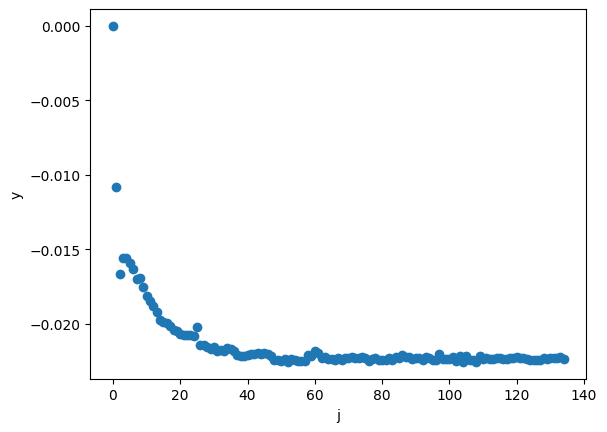

In [ ]:
# 最终还是回归了0.00001
xvalue = []
yvalue = []
for j in range(0,135):
    temp = gamma * np.dot(np.dot(x.iloc[:15,j],V),x.iloc[:15,j]) - np.dot(x.iloc[:15,j], r)
    # print(j, ':', temp)
    xvalue.append(j)
    yvalue.append(temp)
plt.scatter(xvalue,yvalue)
plt.xlabel('j')  
plt.ylabel('y')
# plt.ylim(6,10)
plt.show()

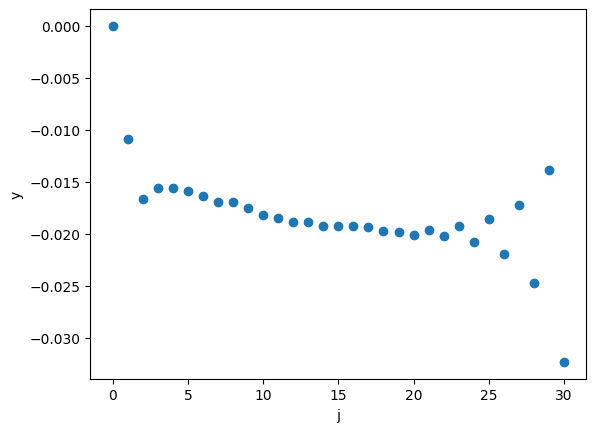

In [30]:
# 将两个迭代终止条件设置为0.0001，经历了12循环停下
xvalue = []
yvalue = []
for j in range(0,31):
    temp = gamma * np.dot(np.dot(x.iloc[:15,j],V),x.iloc[:15,j]) - np.dot(x.iloc[:15,j], r)
    # print(j, ':', temp)
    xvalue.append(j)
    yvalue.append(temp)
plt.scatter(xvalue,yvalue)
plt.xlabel('j')  
plt.ylabel('y')
# plt.ylim(6,10)
plt.show()

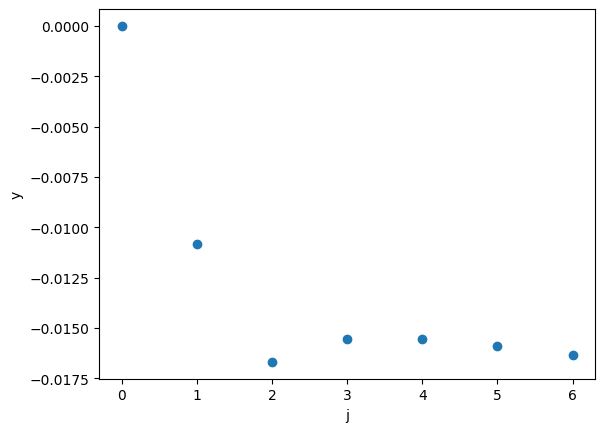

In [24]:
# 将两个迭代终止条件设置为0.001，经历了6循环停下
xvalue = []
yvalue = []
for j in range(0,7):
    temp = gamma * np.dot(np.dot(x.iloc[:15,j],V),x.iloc[:15,j]) - np.dot(x.iloc[:15,j], r)
    # print(j, ':', temp)
    xvalue.append(j)
    yvalue.append(temp)
plt.scatter(xvalue,yvalue)
plt.xlabel('j')  
plt.ylabel('y')
# plt.ylim(6,10)
plt.show()

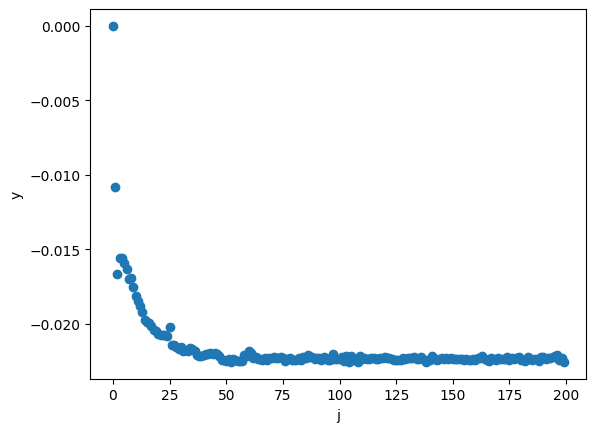

In [21]:
# 将两个迭代终止条件设置为0.00001，经历了200+循环仍未停下
xvalue = []
yvalue = []
for j in range(0,200):
    temp = gamma * np.dot(np.dot(x.iloc[:15,j],V),x.iloc[:15,j]) - np.dot(x.iloc[:15,j], r)
    # print(j, ':', temp)
    xvalue.append(j)
    yvalue.append(temp)
plt.scatter(xvalue,yvalue)
plt.xlabel('j')  
plt.ylabel('y')
# plt.ylim(6,10)
plt.show()

### 对向量b的归一化

In [ ]:
sim = Simulator(backend='mqvector', n_qubits=4)
sim.set_qs(b.values.flatten())
b = DF(sim.get_qs().real)

### 手动计算4*4、b（不）归一的情况是否递减
当时的问题是目标函数图像是递增的，用这个方法排查公式推导的问题。
得到的结论是，4*4的目标函数递减，公式没问题

In [ ]:
V = DF(np.zeros(9).reshape(3,3))
V.iloc[0,0],V.iloc[0,1],V.iloc[1,0],V.iloc[1,1] = 0.000256924,0.0000519,0.0000519,0.000875572
V.iloc[0,2],V.iloc[1,2],V.iloc[2,2] = 0.000141078, 0.000396026, 0.000631838
V.iloc[2,0],V.iloc[2,1] = 0.000141078, 0.000396026

M = DF(np.zeros(16).reshape(4,4))
M.iloc[0,0],M.iloc[0,1],M.iloc[1,0],M.iloc[1,1] = 30*V.iloc[0,0],30*V.iloc[0,1],30*V.iloc[1,0],30*V.iloc[1,1]
M.iloc[0,2],M.iloc[1,2],M.iloc[2,2] = 30*V.iloc[0,2],30*V.iloc[1,2],30*V.iloc[2,2]
M.iloc[2,0],M.iloc[2,1] = 30*V.iloc[2,0],30*V.iloc[2,1]
M.iloc[3,0],M.iloc[3,1],M.iloc[3,2],M.iloc[0,3],M.iloc[1,3],M.iloc[2,3],M.iloc[3,3] = 1,1,1,1,1,1,0
M.iloc[0,0] += 1
M.iloc[1,1] += 1
M.iloc[2,2] += 1
M

In [ ]:
r = DF(np.zeros(3).reshape(3,1))
r.iloc[0,0] = 0.022831028
r.iloc[1,0] = 0.017181949
r.iloc[2,0] = 0.029850742
r

In [ ]:
b = DF(np.zeros(4).reshape(4,1))
b.iloc[0,0] = r.iloc[0,0]
b.iloc[1,0] = r.iloc[1,0]
b.iloc[2,0] = r.iloc[2,0]
b.iloc[3,0] = 1
b